<a href="https://colab.research.google.com/github/Anandharajan/DriverBehaviour/blob/master/Driver_Behaviour_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Use seaborn for pairplot
!pip install -q seaborn


In [3]:
from __future__ import absolute_import, division, print_function

import pathlib

import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.0-rc1


In [4]:
dataset_path = keras.utils.get_file("driver.csv", "https://raw.githubusercontent.com/Anandharajan/DriverBehaviour/master/driver.csv")
dataset_path


8192/1827 [======================================================================================================================================] - 0s 0us/step


'/root/.keras/datasets/driver.csv'

In [5]:
column_names = ['bac','brakpre','steerangle','vehispeed','engispeed','longacc','transvacc','yawrat','accident'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()



,bac,brakpre,steerangle,vehispeed,engispeed,longacc,transvacc,yawrat,accident
46,"0.15,78,80,65,2700,65,25,0.2,0",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,"0.33,45,145,70,2750,-60,40,0.35,0",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,"0.42,55,-125,60,2800,152,25,0.45,0",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,"0.45,10,45,240,6800,-175,140,3.02,1",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,"0.45,7,-60,240,6800,170,25,0.75,0",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
dataset.isna().sum()

bac            0
brakpre       51
steerangle    51
vehispeed     51
engispeed     51
longacc       51
transvacc     51
yawrat        51
accident      51
dtype: int64

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ZeroDivisionError: ignored

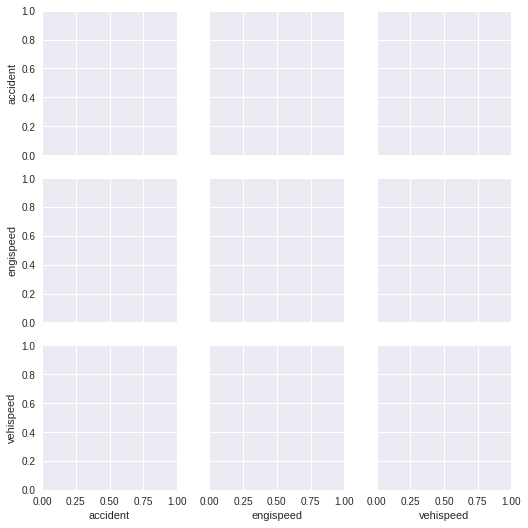

In [8]:
sns.pairplot(train_dataset[["accident", "engispeed", "vehispeed"]], diag_kind="kde")

In [0]:
train_labels = train_dataset.pop('accident')
test_labels = test_dataset.pop('accident')

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("accident")
train_stats = train_stats.transpose()
train_stats

KeyError: ignored

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [15]:
model.summary()

NameError: ignored

In [16]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

NameError: ignored

In [17]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])



NameError: ignored

In [0]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)


In [0]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 54.4%, test acc: 53.9%


In [0]:
# Visualization
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

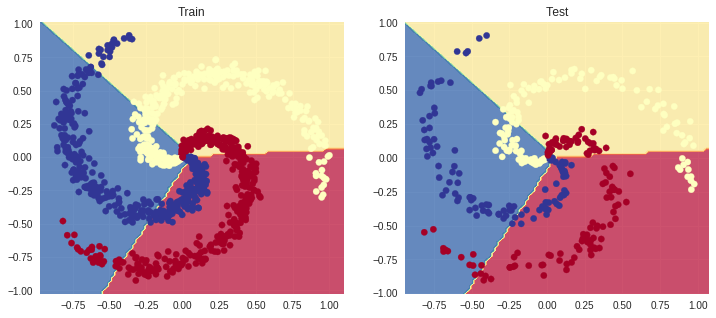

In [0]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

In [0]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

              precision    recall  f1-score   support

           0       0.56      0.53      0.55       125
           1       0.59      0.50      0.54       139
           2       0.47      0.59      0.53       111

   micro avg       0.54      0.54      0.54       375
   macro avg       0.54      0.54      0.54       375
weighted avg       0.55      0.54      0.54       375



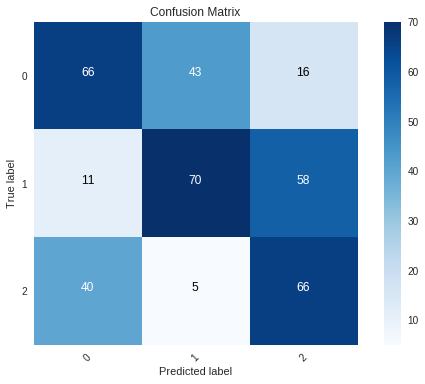

In [0]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
print (classification_report(y_test, pred_test))